In [6]:
from suffix_averaging import SuffixAveragingOptimizer
import os
import json
import itertools
import numpy as np
import pylab
from qiskit import IBMQ, Aer
from qiskit.utils import QuantumInstance
from qiskit.providers.aer.noise import NoiseModel

#General imports
import numpy as np
import ndjson


#Operator Imports
from qiskit.opflow import Z, X, I

from qiskit import Aer
from qiskit.opflow import X, Z, I

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA, NFT, ADAM, GradientDescent, SLSQP, COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

circ_params = []
def load_params(x):
    circ_params.append(x)

iters = 1000
optimizers = [ADAM(lr=0.1, maxiter=iters), NFT(maxiter=iters), SPSA(maxiter=iters), GradientDescent(maxiter=iters) ,SLSQP(maxiter = iters),COBYLA(maxiter=iters), L_BFGS_B(maxiter=iters)]

H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

#qi_100 = QuantumInstance(backend=backend, shots=100, noise_model=noise_model, coupling_map=coupling_map)
#qi_500 = QuantumInstance(backend=backend, shots=500, noise_model=noise_model, coupling_map=coupling_map)
#qi_1000 = QuantumInstance(backend=backend, shots=1000, noise_model=noise_model, coupling_map=coupling_map)


qi_100 = QuantumInstance(backend=backend, shots=100)
qi_500 = QuantumInstance(backend=backend, shots=500)
qi_1000 = QuantumInstance(backend=backend, shots=1000)

instances = [qi_100, qi_500, qi_1000]

converge_cnts = np.empty([len(optimizers), len(instances)], dtype=object)
converge_vals = np.empty([len(optimizers), len(instances)], dtype=object)
improvements = np.empty([len(optimizers), len(instances)], dtype=object)

for j, optimizer in enumerate(optimizers):
    for i, quantum_instance in enumerate(instances):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        path = os.getcwd()
        
        
        if i%3 == 0:
            config_exp = type(optimizer).__name__+"_H2"+"_100shots"+"_"+str(iters)+"iters"+"_noisy"
            dict_exp = {"optimizer": type(optimizer).__name__, "system": "H2", "shots": 100, "iters": iters, "is_noisy": False}
        elif i%3 == 1:
            config_exp = type(optimizer).__name__+"_H2"+"_500shots"+"_"+str(iters)+"iters"+"_noisy"
            dict_exp = {"optimizer": type(optimizer).__name__, "system": "H2", "shots": 500, "iters": iters, "is_noisy": False}
        else:
            config_exp = type(optimizer).__name__+"_H2"+"_1000shots"+"_"+str(iters)+"iters"+"_noisy"
            dict_exp = {"optimizer": type(optimizer).__name__, "system": "H2", "shots": 1000, "iters": iters, "is_noisy": False}


        filename = "circ_params_"+config_exp
            
        suffix_optimizer = SuffixAveragingOptimizer(optimizer, suffix_dir = path, suffix_filename = filename, save_params=False, save_averaged_params=False, alpha = 0.1)


        vqe = VQE(ansatz, suffix_optimizer, callback = store_intermediate_result, quantum_instance=quantum_instance)
        #vqe = VQE(ansatz, suffix_optimizer, callback=store_intermediate_result, quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(operator=H2_op)
        converge_cnts[j,i] = np.asarray(counts)
        converge_vals[j,i] = np.asarray(values)
        improvements[j,i] = converge_vals[j][i][-2]-result.optimal_value

        dict_exp.update(improvements = improvements[j,i])

        print(config_exp)
        print("sa_result", result.optimal_value)
        print("prev_result", converge_vals[j][i][-2])
        print("improvement", improvements[j,i])


        filename_imp = "suffix_results.ndjson"
        with open(filename_imp, 'a') as f:
            writer = ndjson.writer(f)
            writer.writerow(dict_exp)

Optimizer: ADAM        

/Users/shirotamiya/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/shirotamiya/.pyenv/versions/3.10.3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


ADAM_H2_100shots_1000iters_noisy
sa_result -0.9030355874581021
prev_result -0.9233133210549106
improvement -0.02027773359680851
Optimizer: ADAM        

KeyboardInterrupt: 

Optimization complete
sa_result -1.0800973451649771
prev_result -1.0502213317648448
improvement 0.02987601340013235


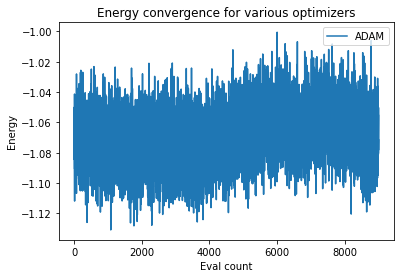

In [2]:
print('\rOptimization complete')
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')
print("sa_result", result.optimal_value)
print("prev_result", converge_vals[0][-2])
print("improvement", converge_vals[0][-2]-result.optimal_value)

In [11]:
import ndjson
filename_imp = "suffix_results.ndjson"
with open(filename_imp, 'a') as f:
    writer = ndjson.writer(f)
    writer.writerow()

array([[None, None, None],
       [None, None, None]], dtype=object)

In [9]:
qi_100.backend

<bound method QasmSimulator.configuration of QasmSimulator('qasm_simulator')>